In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
%cd /content/drive/My \Drive/source/dna_microscopy/2D/diffusion_deep_learning

/content/drive/My Drive/source/dna_microscopy/2D/diffusion_deep_learning


In [13]:
import numpy as np
from scipy.io import mmread, mmwrite
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


#データセットの作成
class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        self.x_train = x_train
        self.t_train = t_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.t_train[idx], dtype=torch.long)

"""
# 今回はテストデータにもラベルがあるので必要ない
class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        self.x_test = x_test

    def __len__(self):
        return self.x_test.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_test[idx], dtype=torch.float)
"""

'\n# 今回はテストデータにもラベルがあるので必要ない\nclass test_dataset(torch.utils.data.Dataset):\n    def __init__(self, x_test):\n        self.x_test = x_test\n\n    def __len__(self):\n        return self.x_test.shape[0]\n\n    def __getitem__(self, idx):\n        return torch.tensor(self.x_test[idx], dtype=torch.float)\n'

In [15]:
#データの読み込み
#amt.shape==(nSample * 9, nBeads**2 + 1), 最後の1列は各レコードのターゲットになっている
amt = mmread("adjMatTargetsTest.mtx").toarray()
data = amt[:,:-1]
target = amt[:,-1]

#trainval_dataset = train_dataset(data[:-test_size,:], np.array(target[-test_size:],dtype=int))
data_dataset = train_dataset(data, np.array(target, dtype=int))

# 読み込んだデータをdatasetにしたものをtrain_dataset, val_dataset, test_datasetとに分割
val_size, test_size = 10, 10
trainval_dataset, test_dataset = torch.utils.data.random_split(data_dataset, [len(data_dataset)-test_size, test_size])
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-val_size, val_size])

"""
#####################
#digit.matによるテスト
from scipy.io import loadmat
val_size, test_size = 100, 200
# load data
data = loadmat('digit.mat')
train = data['X'].transpose(2, 1, 0)[1:]   # train.shape == (10, 500, 256)
test = data['T'].transpose(2, 1, 0)[1:]    # test.shape == (10, 200, 256)
train_target = np.array([i for i in range(1,train.shape[0]+1) for j in range(train.shape[1])],dtype=int)
test_target = np.array([i for i in range(1,test.shape[0]+1) for j in range(test.shape[1])],dtype=int)
train = np.concatenate(train)
test = np.concatenate(test)
in_dim = train.shape[1]
trainval_dataset = train_dataset(train,train_target)
test_dataset = train_dataset(test,test_target)

# trainval_datasetをtrain_datasetとval_datasetに分割
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-val_size, val_size])
#####################
"""

transform = transforms.ToTensor()
train_dataset.transform = transform
val_dataset.transform = transform
test_dataset.transform = transform

batch_size = 32

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

TypeError: ignored

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3
in_dim = data.shape[1]  #datasetになってからではデータの情報は得られないのであらかじめ取得しておく

net = nn.Sequential(
    nn.Linear(in_dim, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 9)
)

def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)        
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)

net.apply(init_weights)

net.to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

n_epochs = 50

train_accuracy = []
valid_accuracy = []

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    net.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        net.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device) - 1

        y = net.forward(x)  # 順伝播

        loss = loss_function(y, t)

        loss.backward()  # 誤差の逆伝播

        optimizer.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        
        losses_train.append(loss.tolist())

    train_accuracy.append(acc_train/n_train)

    net.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device) - 1

        y = net.forward(x)  # 順伝播

        loss = loss_function(y, t)
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    valid_accuracy.append(acc_val/n_val)

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))    

EPOCH: 0, Train [Loss: 2.198, Accuracy: 0.106], Valid [Loss: 2.196, Accuracy: 0.102]
EPOCH: 1, Train [Loss: 2.156, Accuracy: 0.171], Valid [Loss: 2.033, Accuracy: 0.152]
EPOCH: 2, Train [Loss: 1.717, Accuracy: 0.315], Valid [Loss: 1.527, Accuracy: 0.366]
EPOCH: 3, Train [Loss: 1.325, Accuracy: 0.454], Valid [Loss: 1.417, Accuracy: 0.323]
EPOCH: 4, Train [Loss: 1.086, Accuracy: 0.545], Valid [Loss: 1.368, Accuracy: 0.399]
EPOCH: 5, Train [Loss: 0.953, Accuracy: 0.593], Valid [Loss: 1.381, Accuracy: 0.412]
EPOCH: 6, Train [Loss: 0.849, Accuracy: 0.637], Valid [Loss: 1.429, Accuracy: 0.391]
EPOCH: 7, Train [Loss: 0.766, Accuracy: 0.673], Valid [Loss: 1.599, Accuracy: 0.388]
EPOCH: 8, Train [Loss: 0.686, Accuracy: 0.721], Valid [Loss: 1.783, Accuracy: 0.366]
EPOCH: 9, Train [Loss: 0.613, Accuracy: 0.757], Valid [Loss: 1.933, Accuracy: 0.389]
EPOCH: 10, Train [Loss: 0.570, Accuracy: 0.767], Valid [Loss: 2.118, Accuracy: 0.374]
EPOCH: 11, Train [Loss: 0.517, Accuracy: 0.795], Valid [Loss: 2.

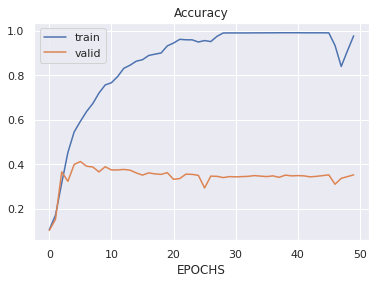

In [0]:
import seaborn as sns
sns.set()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(n_epochs), train_accuracy, label="train")
ax.plot(range(n_epochs), valid_accuracy, label="valid")
ax.set_title("Accuracy")
ax.set_xlabel("EPOCHS")
ax.legend()
#plt.show()
plt.savefig("result.png")

In [0]:
for epoch in range(n_epochs):
    losses_test = []

    net.eval()
    n_test = 0
    acc_test = 0
    for x, t in dataloader_test:
        # WRITE ME
        n_test += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device) - 1

        y = net.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        

        acc_test += (pred == t).float().sum().item()
        losses_test.append(loss.tolist())

    print('EPOCH: {}, Test [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_test),
        acc_test/n_test,
    ))

EPOCH: 0, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 1, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 2, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 3, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 4, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 5, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 6, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 7, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 8, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 9, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 10, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 11, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 12, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 13, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 14, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 15, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 16, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 17, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 18, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 19, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 20, Test [Loss: 2.233, Accuracy: 0.365]
EPOCH: 21, Test [Loss: 